# Kapitel 1: Erste Einblicke aus Textdaten gewinnen

## Setup

Es werden die Verzeichnisse festgelegt. Wenn Sie mit Google Colab arbeiten: Die erforderlichen Dateien werden kopiert und die erforderlichen Bibliotheken installiert.

## Hinweis

Mit ### ergänzte Code-Zeilen geben Werte an, die angepasst werden können.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
    os.system(f'wget {GIT_ROOT}/ch01/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Python-Einstellungen laden

Allgemeine Importe, Standardwerte für die Formatierung in Matplotlib, Pandas usw.

In [2]:
%run "$BASE_DIR/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# Explorative Datenanalyse


## Einführung in den Datensatz


In [3]:
pd.options.display.max_colwidth = 150 ### 
file = "un-general-debates-blueprint.csv"
file = f"{BASE_DIR}/data/un-general-debates/un-general-debates-blueprint.csv.gz" 
df = pd.read_csv(file)
df.sample(5, random_state=53) ###

,session,year,country,country_name,speaker,position,text
3871,51,1996,PER,Peru,Francisco Tudela Van Breughel Douglas,Minister for Foreign Affairs,"﻿At the outset, allow me,\nSir, to convey to you and to this Assembly the greetings\nand congratulations of the Peruvian people, as well as\ntheir..."
4697,56,2001,GBR,United Kingdom,Jack Straw,Minister for Foreign Affairs,"﻿Please allow me\nwarmly to congratulate you, Sir, on your assumption of\nthe presidency of the fifty-sixth session of the General\nAssembly.\nThi..."
6767,67,2012,COD,"Congo, The Democratic Republic of the",Joseph Kabila Kabange,President,"﻿At\nthe outset, I should like to join previous speakers in\ncongratulating Mr. Vuk Jeremić and the other members\nof the Bureau on his election t..."
7243,69,2014,MYS,Malaysia,Dato’ Sri Mohd Najib bin Tun Haji Abdul Razak,Prime Minister,I would like to begin \nby congratulating the President on his election. His \nwisdom and experience will stand him in good stead as \nhe guides t...
6420,65,2010,HND,Honduras,Mario Canahuati,Minister for Foreign Affairs,"\nOn behalf of the people and Government of Honduras, \nI wish to recognize Mr. Ali Abdussalam Treki for his \nleadership during the previous sess..."


# 1. Blueprint: Mit Pandas einen Überblick über die Daten gewinnen


## Berechnung einiger statistischer Werte über Spalten


In [4]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.00,49.61,12.89,25.00,39.00,51.00,61.00,70.00
year,7507.00,1994.61,12.89,1970.00,1984.00,1996.00,2006.00,2015.00
length,7507.00,17967.28,7860.04,2362.00,12077.00,16424.00,22479.50,72041.00


In [5]:
df[['country', 'speaker']].describe(include='O').T

,count,unique,top,freq
country,7507,199,ALB,46
speaker,7480,5428,Seyoum Mesfin,12


## Prüfen auf fehlende Daten


In [6]:
df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
length             0
dtype: int64

In [7]:
df['speaker'].fillna('unkown', inplace=True)

In [8]:
df[df['speaker'].str.contains('Fischer')]['speaker'].value_counts()

Fischer                5
Joschka Fischer        4
Mr. Fischer            1
Mr. Joschka Fischer    1
Heinz Fischer          1
Name: speaker, dtype: int64

## Ausgabe einiger Werteverteilungen


<AxesSubplot:>

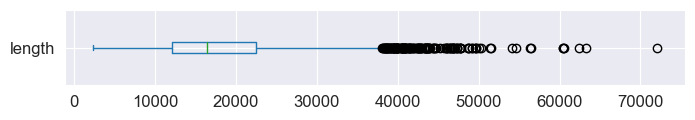

In [9]:
df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<AxesSubplot:ylabel='Frequency'>

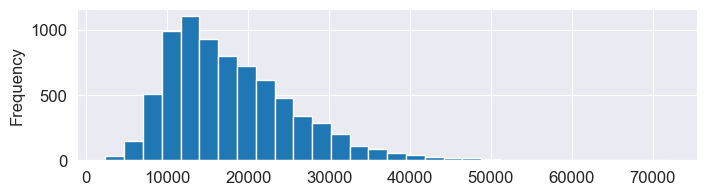

In [10]:
df['length'].plot(kind='hist', bins=30, figsize=(8,2))

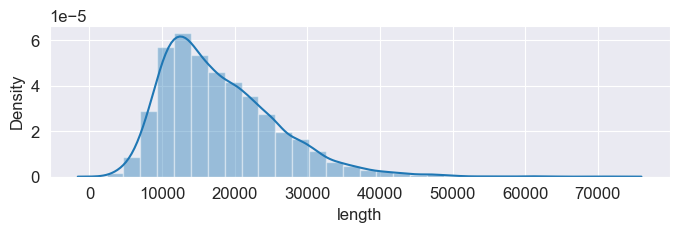

In [11]:
# Gaussche Dichte-Schätzung
import seaborn as sns

plt.figure(figsize=(8, 2))
sns.distplot(df['length'], bins=30, kde=True);

## Vergleich von Wertverteilungen zwischen Kategorien (Ländern)


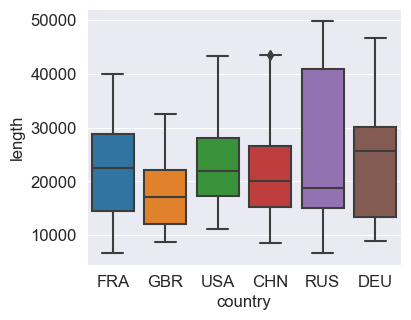

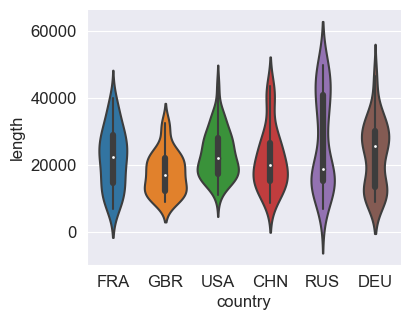

In [12]:
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS', 'DEU'])
g = sns.catplot(data=df[where], x="country", y="length", kind='box')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###
g = sns.catplot(data=df[where], x="country", y="length", kind='violin')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###

## Visualisierung von Zeitverläufen


<AxesSubplot:title={'center':'Number of Countries'}, xlabel='year'>

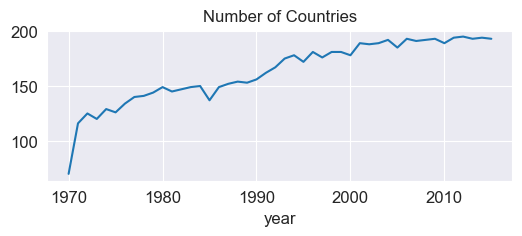

In [13]:
df.groupby('year').size().plot(title="Number of Countries", figsize=(6,2))

<AxesSubplot:title={'center':'Avg. Speech Length'}, xlabel='year'>

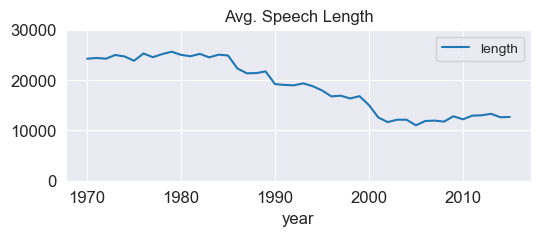

In [14]:
df.groupby('year').agg({'length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000), figsize=(6,2))

# 2. Blueprint: Aufbau einer einfachen Pipeline zur Textvorverarbeitung


## Tokenisierung mit regulären Ausdrücken


In [15]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [16]:
text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


## Behandlung von Stopp-Wörtern


In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kleme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
import nltk

stopwords = set(nltk.corpus.stopwords.words('english'))

In [19]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [20]:
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

## Verarbeitung einer Pipeline mit einer Zeile Code


In [21]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [22]:
df['tokens'] = df['text'].progress_apply(prepare, pipeline=pipeline)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [23]:
df['num_tokens'] = df['tokens'].progress_map(len)

  0%|          | 0/7507 [00:00<?, ?it/s]

# 3. Blueprint: Wörter zählen mit einem Counter


In [24]:
from collections import Counter

tokens = tokenize("She likes my cats and my cats like my sofa.")

counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [25]:
more_tokens = tokenize("She likes dogs and cats.")
counter.update(more_tokens)
print(counter)

Counter({'my': 3, 'cats': 3, 'She': 2, 'likes': 2, 'and': 2, 'like': 1, 'sofa': 1, 'dogs': 1})


In [26]:
counter = Counter()

_ = df['tokens'].map(counter.update)

In [27]:
pp.pprint(counter.most_common(10)) ###

[('nations', 124508),
 ('united', 120763),
 ('international', 117223),
 ('world', 89421),
 ('countries', 85734),
 ('peace', 72625),
 ('development', 62632),
 ('states', 59713),
 ('people', 59338),
 ('security', 58425)]


In [28]:
from collections import Counter ###
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # Token verarbeiten und Zähler aktualisieren
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # Zähler erstellen und alle Daten durchlaufen
    counter = Counter()
    df[column].progress_map(update)

    # Zähler in data frame umwandeln
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [29]:
freq_df = count_words(df)
freq_df.head(10) ###

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734
peace,72625
development,62632
states,59713
people,59338


In [30]:
# Top-Wörter mit 9 oder mehr Zeichen
count_words(df, column='text', 
            preprocess=lambda text: re.findall(r"\w{9,}", text)).head(10) ###

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
international,106974
countries,82934
development,51334
Government,35528
community,34397
Organization,33763
political,32880
developing,25177
situation,22471


#  4. Blueprint: Erstellen eines Frequenzdiagramms


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

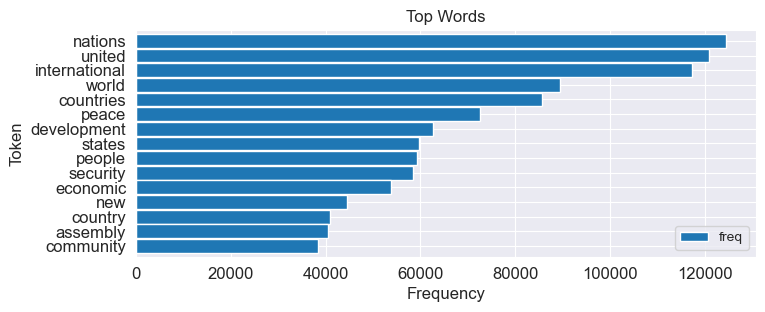

In [31]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3)) ###
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# 5. Blueprint: Erstellen von Word Clouds


(-0.5, 399.5, 199.5, -0.5)

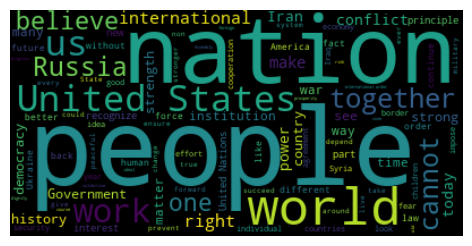

In [32]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = df.query("year==2015 and country=='USA'")['text'].values[0] ###

plt.figure(figsize=(6, 3)) ###
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

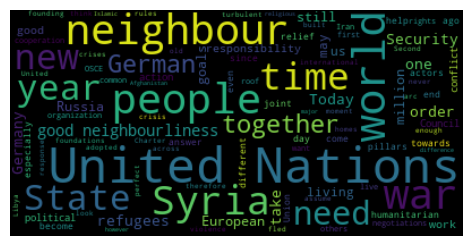

In [33]:
text = df.query("year==2015 and country=='DEU'")['text'].values[0] ###

plt.figure(figsize=(6, 3)) ###
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [34]:
from wordcloud import WordCloud 
from collections import Counter 

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # Umwandlung eines Daat Frames in ein Dictionary
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # Stoppwörter im Frequenzzähler filtern
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

  0%|          | 0/193 [00:00<?, ?it/s]

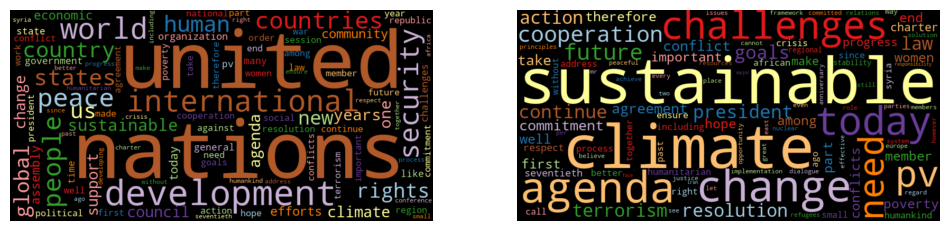

In [35]:
freq_2015_df = count_words(df[df['year']==2015])
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_2015_df['freq'], max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)

# 6. Blueprint: Ranking mit TF-IDF


In [36]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # Token zählen
    counter = Counter()
    df[column].progress_map(update)

    # Data frame erstellen und idf berechnen
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [37]:
idf_df = compute_idf(df)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [38]:
# Stichprobe von IDF-Werten
# hohe IDF bedeutet seltener (interessanter) Begriff
idf_df.sample(10)

,df,idf
token,,
treadmill,4,7.64
congenital,6,7.23
zine,22,5.93
mozambique,956,2.16
veering,7,7.08
laboratories,28,5.69
al-hamdi,6,7.23
a11,14,6.38
huguenots,2,8.33


In [39]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [40]:
# es gilt: verbinden ist schneller
freq_df = freq_df.join(idf_df)
freq_df['tfidf'] = freq_df['freq'] * freq_df['idf']

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

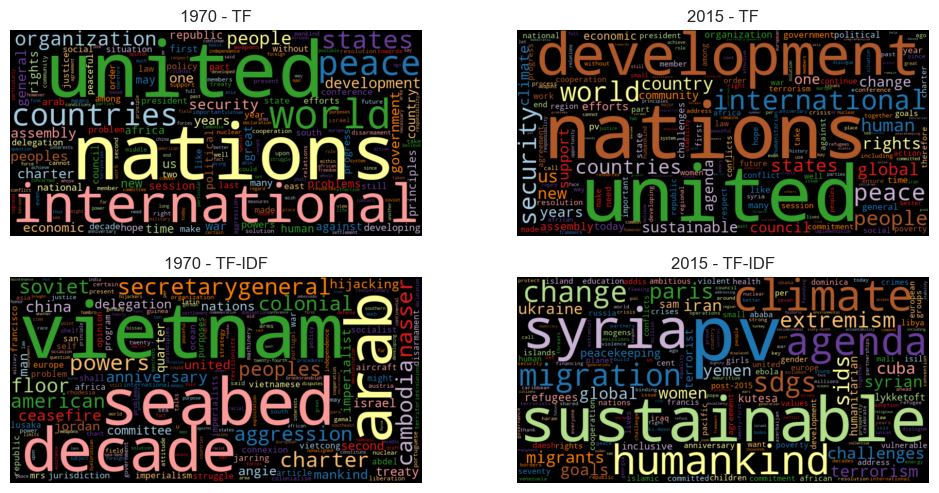

In [41]:
freq_1970 = count_words(df[df['year'] == 1970])
freq_2015 = count_words(df[df['year'] == 2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

plt.figure(figsize=(12,6)) ###
plt.subplot(2,2,1)###
wordcloud(freq_1970['freq'], title='1970 - TF', 
          stopwords=['twenty-fifth', 'twenty-five'])
plt.subplot(2,2,2)###
wordcloud(freq_2015['freq'], title='2015 - TF', 
          stopwords=['seventieth'])
plt.subplot(2,2,3)###
wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF', 
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])
plt.subplot(2,2,4)###
wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF', 
          stopwords=['seventieth'])

# 7. Blueprint: Suche nach einem Schlüsselwort im Kontext (KWIC)


In [42]:
import textacy

if textacy.__version__ < '0.11': # textacy Version kleiner 0.11
    from textacy.text_utils import KWIC
    
else: # textacy Version 0.11.x oder höher
    from textacy.extract.kwic import keyword_in_context

    def KWIC(*args, **kwargs):
        # Aufruf von keyword_in_context mit allen Parametern außer 'print_only'
        return keyword_in_context(*args, 
                           **{kw: arg for kw, arg in kwargs.items() 
                            if kw != 'print_only'})

In [43]:
def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True, 
                              window_width=window, print_only=False))

    kwic_list = []
    doc_series.progress_map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [44]:
random.seed(22) ###
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=10)

  0%|          | 0/193 [00:00<?, ?it/s]

10 random samples out of 73 contexts for 'sdgs':
 of our planet and its people. The   SDGs   are a tangible manifestation of th
nd, we are expected to achieve the   SDGs   and to demonstrate dramatic develo
ead by example in implementing the   SDGs   in Bangladesh. Attaching due impor
the Sustainable Development Goals (  SDGs  ). We applaud all the Chairs of the
new Sustainable Development Goals (  SDGs  ) aspire to that same vision. The A
must ensure the realization of the   SDGs   in a timely manner. We hope that t
the Sustainable Development Goals (  SDGs  ) 15-29664 21/25  A/70/PV.23 01/10
, to ensure the realization of the   SDGs  . The Commonwealth of Dominica is t
le of the century. In adopting the   SDGs  , the Marshall Islands cannot affor
the Sustainable Development Goals (  SDGs  ). That was brilliant. However, all


# 8. Blueprint: Analyse von N-Grammen


In [45]:
def ngrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print("|".join(ngrams(tokens, 2)))

the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


In [46]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: visible manifestation|global climate|climate change
Trigrams: global climate change


In [47]:
df['bigrams'] = df['text'].progress_apply(prepare, pipeline=[str.lower, tokenize]) \
                          .progress_apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(10) ###

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856
developing countries,18511
united states,12363
middle east,12121
south africa,11105


In [48]:
idf_df = compute_idf(df) ### sicherheitshalber neu initialisieren
# Verkettung des vorhandenen IDF-Data Frames mit Bigram-IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year'] == 2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

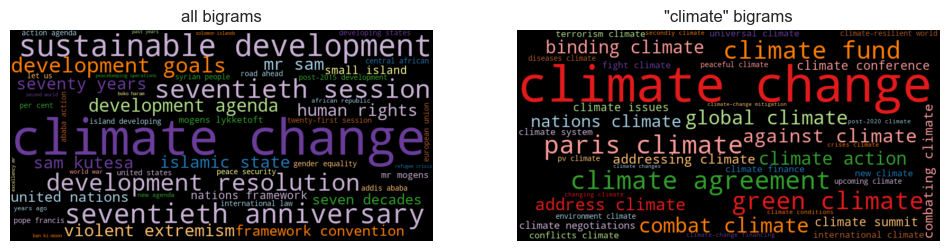

In [49]:
plt.figure(figsize=(12,6)) ###
plt.subplot(1,2,1) ###
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

plt.subplot(1,2,2) ###
where = freq_df.index.str.contains('climate')
wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

# 9. Blueprint: Vergleich von Häufigkeiten über Zeitintervalle und Kategorien hinweg


## Erstellen von Frequenz-Zeitleisten


In [50]:
def count_keywords(tokens, keywords): 
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [51]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']

print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


In [52]:
def count_keywords_by(df, by, keywords, column='tokens'):
    
    df = df.reset_index(drop=True) # wenn der übergebene Data Frame Lücken im Index aufweist
    freq_matrix = df[column].progress_apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by] # die Spalte(n) der Gruppierung kopieren
    
    return freq_df.groupby(by=by).sum().sort_values(by)

In [53]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [54]:
pd.options.display.max_rows = 4

In [55]:
pd.options.display.max_rows = 60

<AxesSubplot:xlabel='year'>

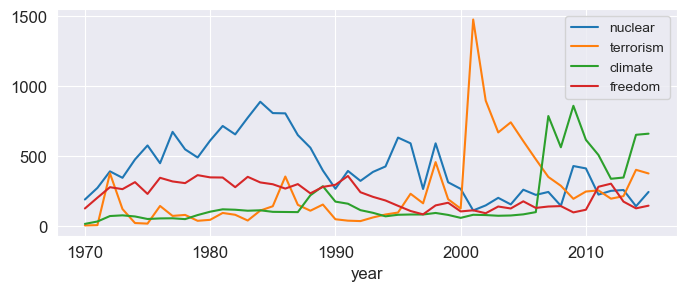

In [56]:
freq_df.plot(kind='line', figsize=(8, 3))

In [57]:
random.seed(23) ###
# Analyse der Erwähnungen von "climate" vor 1980
kwic(df.query('year < 1980')['text'], 'climate', window=35, print_samples=10) ###

  0%|          | 0/1245 [00:00<?, ?it/s]

10 random samples out of 581 contexts for 'climate':
ation with a view to replacing the   climate   of fear, mistrust and hatred by to
ntributing to the maintenance of a   climate   of peace, harmony and understandin
ges in the international political   climate  . There is increasing awareness of 
rian-Israeli front, have created a   climate   which favors the continuation of n
 that, far from noting a promising   climate   in the most critical areas of inte
e very pleased with the propitious   climate   that prevailed in its deliberation
ort, the chances of developing the   climate   of cooperation and accommodation w
in other key areas. But in the new   climate  , consideration of these issues wil
e among the great Powers. This new   climate   will perhaps make it possible for 
vertheless on the achievement of a   climate   of peace in both internal and exte


## Erstellen von Frequenz-Heatmaps


  0%|          | 0/7507 [00:00<?, ?it/s]

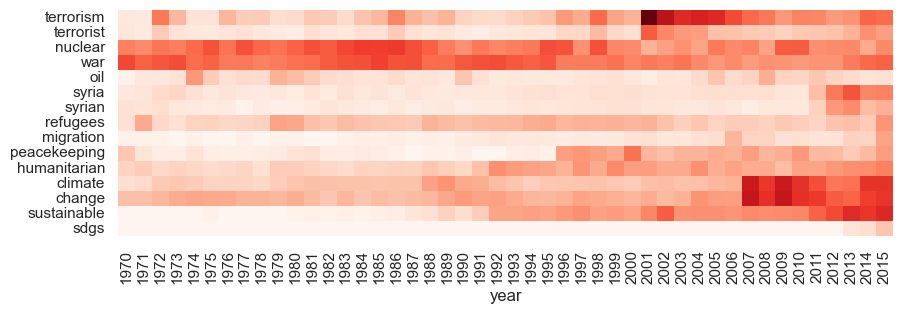

In [58]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil',
            'syria', 'syrian', 'refugees', 'migration', 'peacekeeping', 
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs']  

freq_df = count_keywords_by(df, by='year', keywords=keywords)

# Berechnung der relativen Häufigkeit auf der Grundlage der Gesamtzahl der Token pro Jahr
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
# Anwendung der Quadratwurzel als sublinearer Filter für besseren Kontrast
freq_df = freq_df.apply(np.sqrt)

plt.figure(figsize=(10, 3)) ###
sns.set(font_scale=1) ###
sns.heatmap(data=freq_df.T, 
            xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1) ###